In [1]:
import os
os.environ['HF_HOME'] = "/home/max4c/.cache/huggingface/"
os.environ['CUDA_VISIBLE_DEVICES'] = "14"  
from torch.utils.data import DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
from sentence_transformers import SentenceTransformer 

[1717720190.867081] [e89995c8a091:1427704:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Define the SAE model architecture
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the dataset class
class AbsDataset(Dataset):
    def __init__(self, train_fn="./train.json"):
        self.data = json.load(open(train_fn, "r"))
        self.sentences = []
        for item in self.data:
            self.sentences.extend(item['good'])

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

In [3]:
# Load the trained SAE model
input_size = 768  # Adjust based on the dimensionality of your embeddings
hidden_size = 10000  # Adjust based on your SAE architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = SparseAutoencoder(input_size, hidden_size).to(device)
state_dict = torch.load("trained_autoencoder.pth")
autoencoder.load_state_dict(state_dict)
autoencoder.eval()

# Load the sentence transformer model
emb_model = SentenceTransformer("sentence-t5-xxl")

# Load a fraction of the training data
training_data = AbsDataset()[:100] # Load your training data here
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=10)

# Pass the subset of data through the loaded SAE
encoded_representations = []
with torch.no_grad():
    for sentences in train_dataloader:
        embeddings = emb_model.encode(sentences, convert_to_tensor=True, device=device)
        encoded, _ = autoencoder(embeddings)
        encoded_representations.append(encoded.cpu().numpy())

encoded_representations = np.concatenate(encoded_representations, axis=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


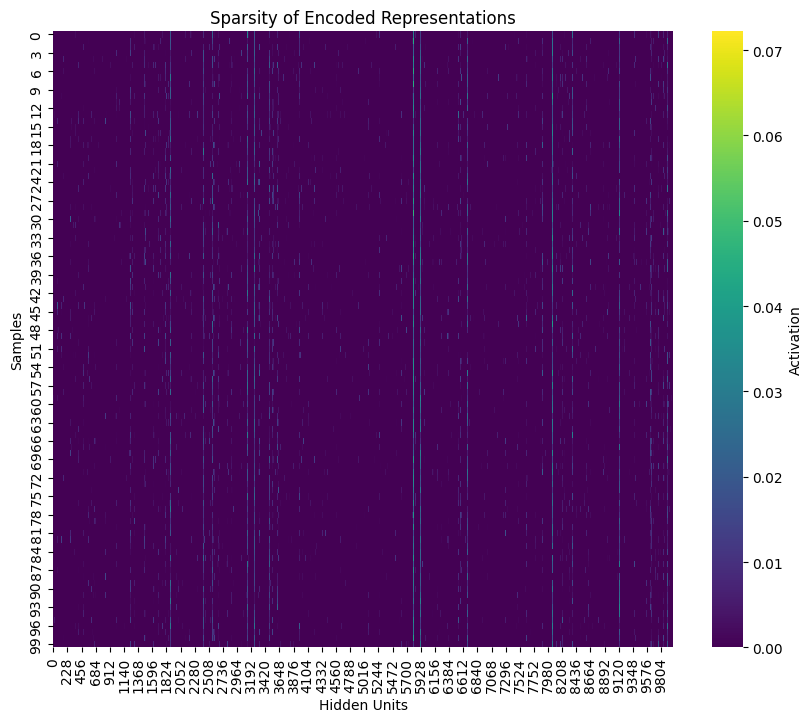

Sparsity ratio (threshold = 0.1): 1.0000


In [4]:
# Visualize the sparsity of encoded representations
plt.figure(figsize=(10, 8))
sns.heatmap(encoded_representations, cmap="viridis", cbar_kws={"label": "Activation"})
plt.xlabel("Hidden Units")
plt.ylabel("Samples")
plt.title("Sparsity of Encoded Representations")
plt.show()

# Analyze the sparsity of encoded representations
sparsity_threshold = 0.1  # Adjust the threshold as desired
sparsity_mask = np.abs(encoded_representations) < sparsity_threshold
sparsity_ratio = sparsity_mask.sum() / np.prod(encoded_representations.shape)

print(f"Sparsity ratio (threshold = {sparsity_threshold}): {sparsity_ratio:.4f}")